In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [5]:
nombre_csv = 1
de = pd.read_csv(f'Datos_entrenamiento/{nombre_csv}_e.csv')
dp = pd.read_csv(f'Datos_prueba/{nombre_csv}_p.csv')

In [6]:
# Contamos las ocurrencias de cada nivel de estrés en la nueva columna
conteo_nivel_estresde = de['Nivel_estres_1'].value_counts()
conteo_nivel_estresdp = dp['Nivel_estres_1'].value_counts()
print(conteo_nivel_estresde)
print(conteo_nivel_estresdp)

Nivel_estres_1
normal     2784
alerta      792
peligro     360
Name: count, dtype: int64
Nivel_estres_1
normal     1896
alerta      480
peligro     120
Name: count, dtype: int64


In [7]:
# Crear un diccionario para mapear cada categoría única en la columna 'nivel_estres' a un número
mapping = {'normal': 0, 'alerta': 1, 'peligro': 2}

# Mapear las categorías a números utilizando el método map de pandas
de['Nivel_estres_1'] = de['Nivel_estres_1'].map(mapping)
dp['Nivel_estres_1'] = dp['Nivel_estres_1'].map(mapping)
de['Nivel_estres_2'] = de['Nivel_estres_2'].map(mapping)
dp['Nivel_estres_2'] = dp['Nivel_estres_2'].map(mapping)

# Aplicación de CNN

In [8]:
# # Separar características y etiquetas del conjunto de entrenamiento
# X_train = de[['period eating','period other','period resting','period rumination']].values
# y_train = de['Nivel_estres_1'].values
# # Separar características y etiquetas del conjunto de prueba
# X_test = dp[['period eating','period other','period resting','period rumination']].values
# y_test = dp['Nivel_estres_1'].values


In [9]:
# Separar características y etiquetas del conjunto de entrenamiento
X_train = de[['period eating_count', 'period other_count', 'period resting_count', 'period rumination_count']].values
y_train = de['Nivel_estres_2'].values

# Separar características y etiquetas del conjunto de prueba
X_test = dp[['period eating_count', 'period other_count', 'period resting_count', 'period rumination_count']].values
y_test = dp['Nivel_estres_2'].values

In [10]:
# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Expandir a 24 horas de datos para capturar ciclo diario
timesteps = 24
X_train_reshaped = np.array([X_train_scaled[i:i + timesteps] for i in range(len(X_train_scaled) - timesteps)])
y_train = y_train[timesteps:]
X_test_reshaped = np.array([X_test_scaled[i:i + timesteps] for i in range(len(X_test_scaled) - timesteps)])
y_test = y_test[timesteps:]


In [12]:
# Ajuste de pesos: Calcular pesos de clase para manejar el desbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [13]:
# Convertir etiquetas a formato categórico
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

In [14]:
# Definir la arquitectura del modelo CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(timesteps, X_train_scaled.shape[1])),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 neuronas para los 3 niveles de estrés
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

# Entrenar el modelo
history = model.fit(X_train_reshaped, y_train_categorical, epochs=10, batch_size=24,
                    validation_data=(X_test_reshaped, y_test_categorical), class_weight=class_weights_dict)



C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6251 - accuracy: 0.4258 - loss: 1.3696 - val_AUC: 0.8778 - val_accuracy: 0.7447 - val_loss: 0.8011
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8481 - accuracy: 0.6836 - loss: 0.7209 - val_AUC: 0.9706 - val_accuracy: 0.9102 - val_loss: 0.4214
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8989 - accuracy: 0.7470 - loss: 0.4487 - val_AUC: 0.9589 - val_accuracy: 0.8722 - val_loss: 0.4403
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9593 - accuracy: 0.8479 - loss: 0.2869 - val_AUC: 0.9734 - val_accuracy: 0.8989 - val_loss: 0.3283
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9800 - accuracy: 0.8901 - loss: 0.1955 - val_AUC: 0.9939 - val_accuracy: 0.9620 - val_loss: 0.1769
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9884 - accuracy: 0.9226 - loss: 0.1411 - val_AUC: 0.9928 - val_accuracy: 0.9559 - val_loss: 0.1590
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 

In [18]:
# Predecir las clases del conjunto de prueba
y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)

# Contamos las ocurrencias de cada nivel de estrés en y_test y y_pred
valores_unicos, conteos = np.unique(y_test, return_counts=True)
valores_unicos1, conteos1 = np.unique(y_pred, return_counts=True)
ocurrencias = dict(zip(valores_unicos, conteos))
ocurrenciaspre = dict(zip(valores_unicos1, conteos1))

# Mostramos el resultado
print(ocurrencias)
print(ocurrenciaspre)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{0: 2424, 1: 24, 2: 24}
{0: 2402, 1: 41, 2: 29}


# Evaluación

In [16]:
from sklearn.preprocessing import label_binarize

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

y_pred= label_binarize(y_pred, classes=[0, 1, 2])

# Calcular el AUC
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Mostrar métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.982200647249191
Precision: 0.986421243067012
Recall: 0.982200647249191
F1 Score: 0.9837774952468086
ROC AUC: 0.8809009577428331


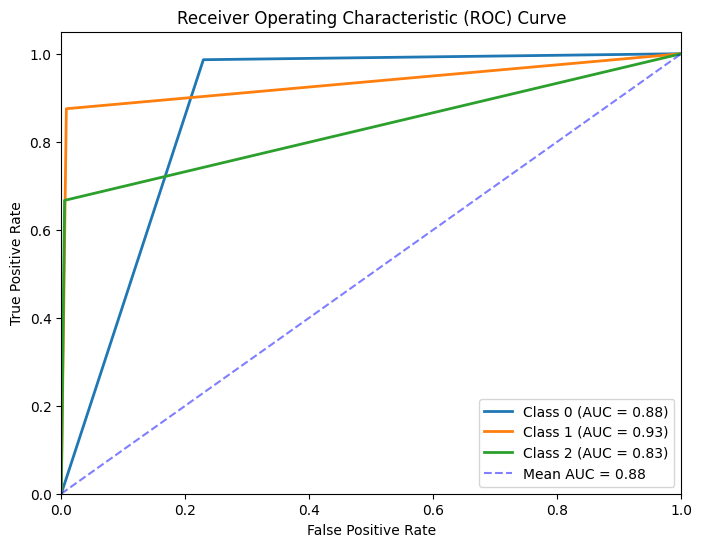

AUC per class: {0: 0.8786097359735973, 1: 0.9334150326797387, 2: 0.8306781045751633}


In [17]:
# Calcular la curva ROC y el AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Extraer los valores
values = roc_auc.values()
# Calcular la media
mean_auc = sum(values) / len(values)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'b--', label=f"Mean AUC = {mean_auc:.2f}", alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
#plt.savefig(f'../Curva_Roc/{nombre_csv}_roc_cnn.png', format='png', dpi=300)
plt.show()
print("AUC per class:", roc_auc)
